## Pre-processing

In [9]:
import numpy as np
import pandas as pd

UG_courses = ["BOA","BOB","BOC","BOE","BSC"]
Df = pd.read_csv("synthetic_Data_truncated_normal_approach2.csv")
print("size of dataframe:",Df.shape)
Df["COURSE_CODE"] = Df["COURSE_CODE"].fillna('not_taking')
Df = Df[Df.columns].fillna('0')
Df.isnull().sum().sum()

Df = Df.loc[Df['COURSE_CODE'] != 'not_taking']
Df = Df.reset_index()
X = Df[Df.columns.difference(['CODE_DESCR_mast','COURSE_CODE'])]
y = Df[['CODE_DESCR_mast','COURSE_CODE']]
print("X has size:",X.shape, " and y has size:",y.shape)


size of dataframe: (24017, 108)
X has size: (5437, 107)  and y has size: (5437, 2)


In [24]:
## select column that needs to do binary encoding 
subject_course_list = []
for course in UG_courses:
    for i in range(0,16):
        subject_course_list += [course+'subject'+str(i+1)]
profile_title_list = X.columns.difference(subject_course_list)

useless_profile_title_list = ['STU_ID_PROXY','UG_course','CODE_DESCR_bach','FACULTY_CODE_mast','LANGUAGE_TEST_SCORE','LANGUAGE_TEST_TYPE']+['FACULTY_CODE_mast']
# data cleaning, to sparse, or useless
useful_profile_title_list= list(set(profile_title_list)-set(useless_profile_title_list))
column_title_need_onehotEncode = ['COURSE_CREDITS_REQ_bach','FACULTY_CODE_bach','LOCATION_CODE_bach','top5_bach_bach',
                                  'AGE_BAND','STATE','HOME_LANGUAGE','ATAR_BAND',
                                  'COURSE_CREDITS_REQ_mast','LOCATION_CODE_mast','STUDY_YEAR_mast','N_SUBJECTS_mast']
X.isnull().sum().sum()

print("X has size:",X.shape)


X has size: (5437, 107)


In [25]:

from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder

####binary encoder
encoder = LabelBinarizer()
# Y_values = encoder.fit_transform(y["COURSE_CODE"].values)
Y_values = y["COURSE_CODE"].values
X_part1 = pd.DataFrame({})
for column in column_title_need_onehotEncode:
    column_values=X[column_title_need_onehotEncode][column].astype(str)
    binarised_x = encoder.fit_transform(column_values.values)
    X_part1 = pd.concat([X_part1,pd.DataFrame(binarised_x)],axis=1)
X_part2 = X[list(set(useful_profile_title_list)-set(column_title_need_onehotEncode))]
X_part2 = X_part2.reset_index(drop=True)
X_values = pd.concat([pd.DataFrame(X_part1),X_part2], axis = 1)

print("X has size:",X_values.shape, " and y has size:",Y_values.shape)


X has size: (5437, 89)  and y has size: (5437,)


# modelling without Synthetic



In [59]:
def accuracy_at_n(n,recomm,Ytest,order = "1_to_n"):
    res = [0]*n
    total = len(Ytest)
    i =[0]*n
    j = list(range(n))[1:]+[n]
    if order == "n_to_1":
        i= list(range(n))
        i = list(map(lambda x: -1*x, i))[1:]+[0]
        j = [n]*n
    Ytest = Ytest.reset_index(drop = True)
    for index, row in recomm.iterrows():
        for each in range(n):
            if Ytest[index] in row.values[i[each]:j[each]]:
                res[each] +=1   
    res = list(map(lambda x:round(x/total,3), res))
    return res,order


In [60]:
from sklearn import metrics

def add_res(n,res,model,method,SynData,X_train,X_test,Y_test):
    Y_pred = model.predict(X_test)
    probs = model.predict_proba(X_test) 
    n=n
    best_n = np.argsort(-probs, axis=1)[:,:-n]
    #then find the associated SOC code for each prediction
    top_class = cls.classes_[best_n]
    #cast to a new dataframe
    top_class_df = pd.DataFrame(data=top_class)    
#     print(top_class_df[:5])
    acc,order = accuracy_at_n(n,top_class_df,Y_test)
    this_row = {"method":method,
            "with Synthetic Data":SynData,
            "Train set size":int(X_train.shape[0]),
            "Test set size":int(X_test.shape[0]),
             "f1_score_weighted":metrics.f1_score(Y_test, Y_pred, average="weighted"),
            "accuracy_score":metrics.accuracy_score(Y_test, Y_pred),}
    for i in range(n):
        this_row["accuracy at "+str(i+1)] = acc[i]
    res = res.append(this_row,ignore_index=True)
    return res



In [61]:
from sklearn.model_selection import train_test_split
import numpy as np
X_train, X_test, Y_train, Y_test = train_test_split(X_values.values, Y_values, test_size=0.2, random_state=27)

res_dict = pd.DataFrame(data = {"method":[],
            "with Synthetic Data":[],
            "Train set size":[],
            "Test set size":[],
             "f1_score_weighted":[],
            "accuracy_score":[],
            })
n=10

In [62]:

import timeit

start = timeit.default_timer()
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

cls = DecisionTreeClassifier()
cls.fit(X_train, Y_train)

res_dict = add_res(n,res_dict,cls,"DecisionTreeClassifier",False,X_train,X_test,Y_test)

stop = timeit.default_timer()
print('Time in seconds: ', stop - start) 

Time in seconds:  0.6259506000001238


D:\Anaconda\ana\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\ana\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [63]:
res_dict

# print(top_class_df)


,method,with Synthetic Data,Train set size,Test set size,f1_score_weighted,accuracy_score,accuracy at 1,accuracy at 10,accuracy at 2,accuracy at 3,accuracy at 4,accuracy at 5,accuracy at 6,accuracy at 7,accuracy at 8,accuracy at 9
0,DecisionTreeClassifier,0.0,4349.0,1088.0,0.541393,0.54136,0.541,0.588,0.543,0.551,0.561,0.567,0.569,0.571,0.585,0.587


In [64]:
import timeit

start = timeit.default_timer()

from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB()
cls.fit(X_train, Y_train)
res_dict = add_res(10,res_dict,cls,"BernoulliNB",False,X_train,X_test,Y_test)
stop = timeit.default_timer()
print('Time in seconds: ', stop - start) 

Time in seconds:  0.8100087000000258


D:\Anaconda\ana\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\ana\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [65]:
import timeit

start = timeit.default_timer()

from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
cls.fit(X_train, Y_train)
res_dict = add_res(10,res_dict,cls,"GaussianNB",False,X_train,X_test,Y_test)

stop = timeit.default_timer()
print('Time in seconds: ', stop - start) 


Time in seconds:  1.59380259999989


D:\Anaconda\ana\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\ana\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [66]:
import timeit
start = timeit.default_timer()

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

grid_params = {'n_neighbors':[40,50,55,60,65,70,75,80,85,90,100],
              'weights':['uniform',],
              'metric':['manhattan']}
grid = GridSearchCV(KNeighborsClassifier(),grid_params,verbose = 1,cv=3,n_jobs = -1)
cls  = grid.fit(X_train, Y_train)
best_parameters = grid.best_params_
print("best parameters are:",best_parameters)
best_result = grid.best_score_
print("best result is :",best_result)

res_dict = add_res(10,res_dict,cls,"KNeighborsClassifier",False,X_train,X_test,Y_test)

stop = timeit.default_timer()
print('Time in seconds: ', stop - start) 

D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


Fitting 3 folds for each of 11 candidates, totalling 33 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 out of  33 | elapsed:   14.4s finished
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best parameters are: {'metric': 'manhattan', 'n_neighbors': 65, 'weights': 'uniform'}
best result is : 0.33731892389054957
Time in seconds:  15.772782899999811


D:\Anaconda\ana\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [67]:
res_dict

,method,with Synthetic Data,Train set size,Test set size,f1_score_weighted,accuracy_score,accuracy at 1,accuracy at 10,accuracy at 2,accuracy at 3,accuracy at 4,accuracy at 5,accuracy at 6,accuracy at 7,accuracy at 8,accuracy at 9
0,DecisionTreeClassifier,0.0,4349.0,1088.0,0.541393,0.541360,0.541,0.588,0.543,0.551,0.561,0.567,0.569,0.571,0.585,0.587
1,BernoulliNB,0.0,4349.0,1088.0,0.535342,0.530331,0.530,0.577,0.532,0.540,0.546,0.554,0.556,0.559,0.571,0.574
2,GaussianNB,0.0,4349.0,1088.0,0.542271,0.534926,0.535,0.583,0.537,0.546,0.551,0.560,0.561,0.563,0.574,0.580
3,KNeighborsClassifier,0.0,4349.0,1088.0,0.225264,0.336397,0.336,0.701,0.457,0.530,0.574,0.606,0.631,0.656,0.671,0.688


# Modelling With Synthetic

In [68]:

X_part2 = X_part2.reset_index(drop = True)
X_part1 = X_part1.reset_index(drop = True)
X_part3 = X[subject_course_list]
X_part3= X_part3.reset_index(drop = True)
X2_values = pd.concat([pd.DataFrame(X_part1),X_part2,X_part3],axis = 1)
print(X2_values.shape)
from sklearn.model_selection import train_test_split
import numpy as np
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2_values.values, Y_values, test_size=0.2, random_state=27)


(5437, 169)


### Decision Tree

In [69]:

import timeit

start = timeit.default_timer()
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

cls = DecisionTreeClassifier()
cls.fit(X2_train, Y2_train)
res_dict = add_res(10,res_dict,cls,"DecisionTreeClassifier",True,X2_train,X2_test,Y2_test)

stop = timeit.default_timer()
print('Time in seconds: ', stop - start) 

Time in seconds:  1.396229299999959


D:\Anaconda\ana\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\ana\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### Naive Bayes

In [70]:
import timeit

start = timeit.default_timer()

from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB()
cls.fit(X2_train, Y2_train)
res_dict = add_res(10,res_dict,cls,"BernoulliNB",True,X2_train,X2_test,Y2_test)

stop = timeit.default_timer()
print('Time in seconds: ', stop - start) 

Time in seconds:  1.2608674999999039


D:\Anaconda\ana\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\ana\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [71]:
import timeit

start = timeit.default_timer()

from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
cls.fit(X2_train, Y2_train)
res_dict = add_res(10,res_dict,cls,"GaussianNB",True,X2_train,X2_test,Y2_test)

stop = timeit.default_timer()
print('Time in seconds: ', stop - start) 


Time in seconds:  1.7741792000001624


D:\Anaconda\ana\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Anaconda\ana\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [72]:
import timeit
start = timeit.default_timer()
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV
grid_params = {'n_neighbors':[30,40,50,55,60,65,70,75,80,85,90,95,100],
              'weights':['uniform'],
              'metric':['manhattan']}
grid2 = GridSearchCV(KNeighborsClassifier(),grid_params,verbose = 1,cv=3,n_jobs = -1)
cls2  = grid2.fit(X2_train, Y2_train)

best_parameters = grid2.best_params_
print("best parameters are:",best_parameters)
best_result = grid2.best_score_
print("best result is :",best_result)
res_dict = add_res(10,res_dict,cls2,"KNeighborsClassifier",True,X2_train,X2_test,Y2_test)

stop = timeit.default_timer()
print('Time in seconds: ', stop - start) 

D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:   11.7s finished
D:\Anaconda\ana\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best parameters are: {'metric': 'manhattan', 'n_neighbors': 55, 'weights': 'uniform'}
best result is : 0.3432973097263739
Time in seconds:  13.612356599999885


D:\Anaconda\ana\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [73]:
res_dict

,method,with Synthetic Data,Train set size,Test set size,f1_score_weighted,accuracy_score,accuracy at 1,accuracy at 10,accuracy at 2,accuracy at 3,accuracy at 4,accuracy at 5,accuracy at 6,accuracy at 7,accuracy at 8,accuracy at 9
0,DecisionTreeClassifier,0.0,4349.0,1088.0,0.541393,0.541360,0.541,0.588,0.543,0.551,0.561,0.567,0.569,0.571,0.585,0.587
1,BernoulliNB,0.0,4349.0,1088.0,0.535342,0.530331,0.530,0.577,0.532,0.540,0.546,0.554,0.556,0.559,0.571,0.574
2,GaussianNB,0.0,4349.0,1088.0,0.542271,0.534926,0.535,0.583,0.537,0.546,0.551,0.560,0.561,0.563,0.574,0.580
3,KNeighborsClassifier,0.0,4349.0,1088.0,0.225264,0.336397,0.336,0.701,0.457,0.530,0.574,0.606,0.631,0.656,0.671,0.688
4,DecisionTreeClassifier,1.0,4349.0,1088.0,0.521555,0.518382,0.518,0.563,0.519,0.526,0.535,0.541,0.543,0.544,0.559,0.562
5,BernoulliNB,1.0,4349.0,1088.0,0.528596,0.526654,0.527,0.569,0.528,0.532,0.543,0.550,0.551,0.551,0.563,0.566
6,GaussianNB,1.0,4349.0,1088.0,0.514264,0.513787,0.514,0.558,0.516,0.521,0.531,0.539,0.540,0.540,0.553,0.556
7,KNeighborsClassifier,1.0,4349.0,1088.0,0.229371,0.337316,0.334,0.692,0.458,0.538,0.577,0.609,0.631,0.648,0.665,0.680


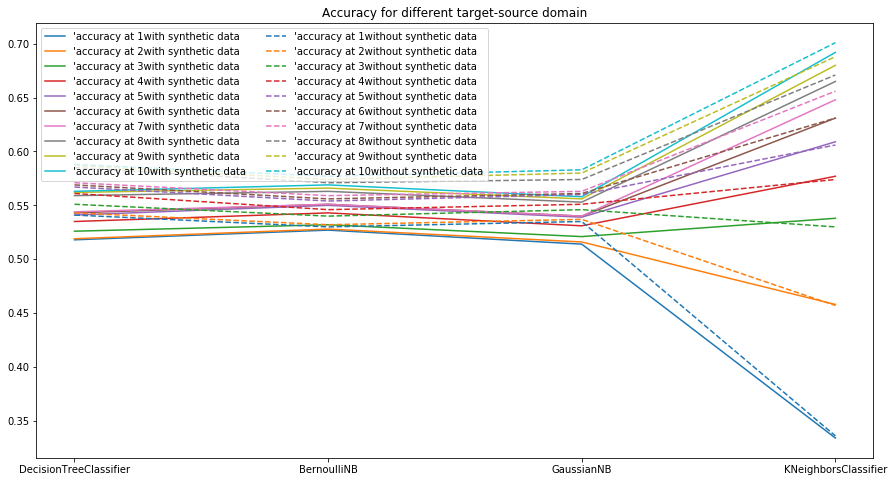

In [74]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))

x = res_dict.loc[res_dict['with Synthetic Data'] == True]["method"]
for i in range(n):
    plt.plot(x,  res_dict.loc[res_dict['with Synthetic Data'] == True]['accuracy at '+str(i+1)],
             label =  "'accuracy at "+str(i+1)+"with synthetic data")
x2 = res_dict.loc[res_dict['with Synthetic Data'] == False]["method"]
for i in range(n):
    plt.plot(x2,  res_dict.loc[res_dict['with Synthetic Data'] == False]['accuracy at '+str(i+1)],
             label =  "'accuracy at "+str(i+1)+"without synthetic data", linestyle='dashed',)

plt.title('Accuracy for different target-source domain')
plt.legend(loc = 'upper left', ncol=2,)
# Display a figure.
plt.show()

In [75]:
res_dict.to_csv('classification result.csv', mode='a', )
